In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data

--2021-10-04 14:47:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/plants/plants.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1690800 (1.6M) [application/x-httpd-php]
Saving to: ‘plants.data.1’

plants.data.1       100%[===================>]   1.61M  5.51MB/s    in 0.3s    

2021-10-04 14:47:26 (5.51 MB/s) - ‘plants.data.1’ saved [1690800/1690800]



In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

state_names = set()
for line in open('plants.data', encoding='ISO-8859-1'):
    name, *states = line.rstrip().split(",")
    state_names.update(states)

features = list(sorted(list(state_names)))
rows = []
for line in open('plants.data', encoding='ISO-8859-1'):
    name, *states = line.rstrip().split(",")
    row = np.zeros(len(features))
    for state in states:
        row[features.index(state)] = 1
    rows.append(np.array(row))
D = np.array(rows)
D = D[D.sum(axis = 1)  >= 2]
frame = pd.DataFrame(D.astype(int), columns = features)
train, test = train_test_split(frame, random_state = 0)

print (len(frame), len(train), len(test))

23215 17411 5804


In [12]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth, association_rules


frequent_itemsets = fpgrowth(train, use_colnames=True, min_support = 0.15)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold = 0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ga),(nc),0.252541,0.253748,0.207225,0.820559,3.233762,0.143144,4.158773
1,(nc),(ga),0.253748,0.252541,0.207225,0.816659,3.233762,0.143144,4.076879
2,(ga),(fl),0.252541,0.255241,0.181035,0.716852,2.808532,0.116576,2.630286
3,(fl),(ga),0.255241,0.252541,0.181035,0.709271,2.808532,0.116576,2.570980
4,(ga),(al),0.252541,0.242490,0.211418,0.837162,3.452350,0.150179,4.651913
...,...,...,...,...,...,...,...,...,...
1038,"(va, md)",(wv),0.191775,0.174947,0.150652,0.785565,4.490303,0.117101,3.847559
1039,"(wv, md)",(va),0.156108,0.240767,0.150652,0.965048,4.008217,0.113066,21.722046
1040,(wv),"(va, md)",0.174947,0.191775,0.150652,0.861129,4.490303,0.117101,5.819982
1041,(me),(ny),0.169950,0.245822,0.155649,0.915850,3.725669,0.113871,8.962305


In [13]:
confidences = []
for i, row in rules.iterrows():
    acondition = None
    for name in row.antecedents:
        if acondition is None:
            acondition = (test[name] == 1)
        else:
            acondition = acondition & (test[name] == 1)
    
    ccondition = None
    for name in row.consequents:
        if ccondition is None:
            ccondition = (test[name] == 1)
        else:
            ccondition = ccondition & (test[name] == 1)
    
    confidences.append (len(test[acondition & ccondition]) / len(test[acondition]))

print ("test condidence = %.2f, alen = %.2f, clen = %.2f" % (np.mean(confidences), 
                                                            rules.antecedents.apply(len).mean(), 
                                                            rules.consequents.apply(len).mean()))

test condidence = 0.84, alen = 1.72, clen = 1.40


In [3]:
from spn.algorithms.Inference import log_likelihood
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian, Bernoulli

ptypes = [Bernoulli] * len(features)

In [4]:
import warnings
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.Base import Context


net = learn_parametric(D, 
                       ds_context = Context(parametric_types=ptypes).add_domains(D), 
                       rows = "gmm", ohe=True,
                       min_instances_slice = len(D)/100)

/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)
/home/saurabh/miniconda3/lib/python3.7/site-packages/sklearn/cross_decomposition/_pls.py:98: ConvergenceWarning: Maximum number of iterations reached
  ConvergenceWarning)


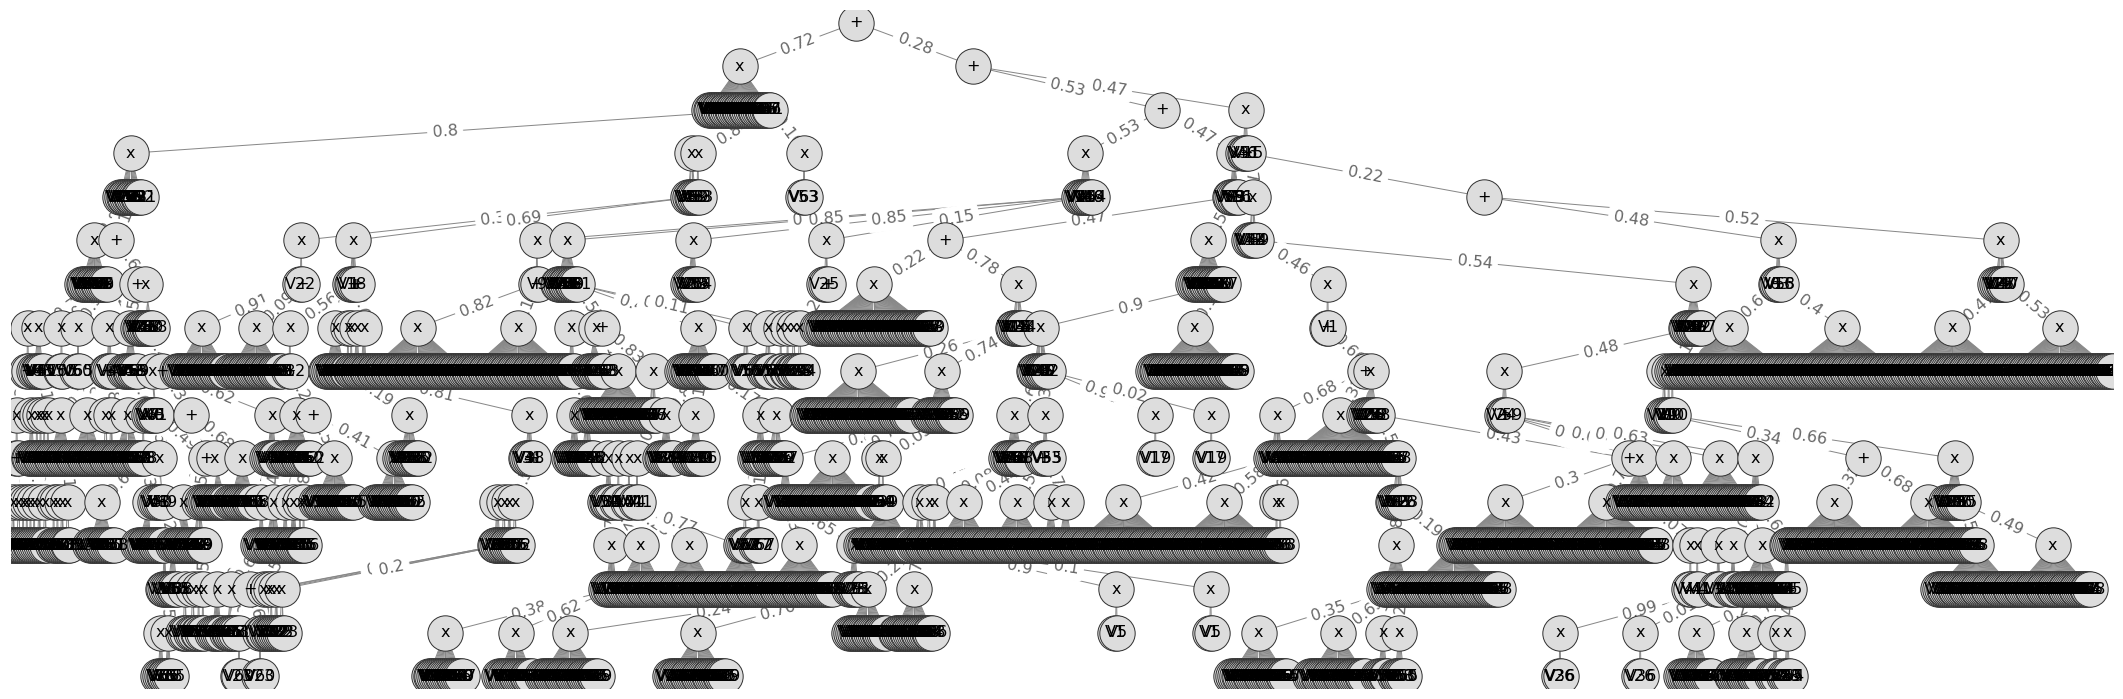

In [8]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 10))
plot_spn(net)

In [9]:
import csi 
import importlib 
importlib.reload(csi)

<module 'csi' from '/home/saurabh/Documents/Projects/QC/SPFlow/src/csi.py'>

In [5]:
def format_clause(clause):
    parts = []
    for subclause in clause.split(" and "):
        a, sign, b = subclause.split(" ")
        # i = names.index(a)
        v = b #value_text[i][int(b)]
        if ((sign, b) == ('==', '1')) or ((sign, b) == ('!=', '0')):
            parts.append("%s" % (a))
        else:
            parts.append("~%s" % (a))
    return " & ".join(parts)
def format_rule(rule):
    antecedent, consequent, score, support = rule
    
    anodes = [' | '.join(["(%s)"% format_clause(clause) for clause in node]) for node in antecedent]
    antecedent = ' & '.join([node if node.startswith("(") else "(%s)" % node for node in anodes])
    cnodes = ["(%s)" % ",".join(node) for node in consequent]
    consequent = ", ".join(cnodes)
    return antecedent, consequent, round(score, 4), min(support, len(D))

In [21]:
categorical = [True]*len(features)
csi.annotate(net, features, categorical, min_impurity_decrease=0.1, min_instances_slice = len(D)/20)
for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    print ("{%s} => {%s} (%.2f, %d)" % rule, end="\n\n")

{(~ny)} => {(ct), (dc), (de), (dengl), (fraspm), (gl), (ia), (il), (in), (lb), (mb), (me), (mi), (mn), (nb), (nd), (nf), (nh), (nj), (ns), (nu), (oh), (on), (pe), (qc), (ri), (vt), (wi), (wv), (ab,ak,al,ar,az,bc,ca,co,fl,ga,id,ks,ky,la,mo,ms,mt,nc,ne,nm,nt,nv,ok,or,sc,sd,sk,tn,tx,ut,va,wa,wy,yt), (hi), (ma), (md), (ny), (pa), (pr,vi)} (0.99, 25063)

{(ny) & (pa & ny)} => {(ny), (pa), (ab,ak,al,ar,az,bc,ca,co,ct,dc,de,dengl,fl,fraspm,ga,hi,ia,id,il,in,ks,ky,la,lb,ma,mb,md,me,mi,mn,mo,ms,mt,nb,nc,nd,ne,nf,nh,nj,nm,ns,nt,nu,nv,oh,ok,on,or,pe,pr,qc,ri,sc,sd,sk,tn,tx,ut,va,vi,vt,wa,wi,wv,wy,yt), (gl)} (0.57, 4607)

{(~ny) & (~fl)} => {(ga), (ky), (la), (ms), (nc), (sc), (tn), (va), (ab,ak,az,bc,ca,co,id,ks,mt,ne,nm,nt,nv,ok,or,sd,sk,tx,ut,wa,wy,yt), (al), (ar), (fl), (mo)} (0.99, 19943)

{(~ny) & (fl)} => {(ab), (nt), (sk), (yt), (ak,al,ar,az,bc,ca,co,fl,ga,id,ks,ky,la,mo,ms,mt,nc,ne,nm,nv,ok,or,sc,sd,tn,tx,ut,va,wa,wy)} (0.68, 5120)

{(~ny) & (~pr)} => {(pr), (vi)} (0.99, 21119)

{(~ny) & 

In [10]:
import pandas as pd
import csi
train = D
categorical = [True]*len(features)
csi.annotate(net, features, categorical, min_impurity_decrease=0.1, min_instances_slice = len(train)/20)
rows = []

for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    t = ("$%s$ \t %s \t %.2f \t %d" % rule)
    t = t.replace('~', '\\neg ')
    t = t.replace("&", "\land").replace("|", "\lor")
    t = t.replace("==", "=").replace("!=", "\\neq")
    t = t.replace("%3F", "")
    rows.append (t.split("\t"))
pd.DataFrame(rows, columns = ['Antecedent', 'Consequent', 'Score', 'Support']).to_csv("plants_csi.csv", index=False)